In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE

# Load data

In [2]:
# load data - two formats, one with categorical data encoded, one not
df_nocodes = pd.read_csv('hotel_cleaned_no_encoding.csv')
df_codes = pd.read_csv('hotel_cleaned.csv')

In [3]:
# make lists of columns
num_cols = []
cat_cols = []

for col in df_nocodes.columns:  # arbitrary cut off, some of the num_cols are still sort of categorical
    if (df_nocodes[col].dtype=='object') or (df_nocodes[col].nunique() <= 12):  # to catch arrival month
        cat_cols.append(col)
    else:
        num_cols.append(col)

cat_cols.remove('is_canceled')  # remove target variable

# because it's easier to see that it's noise
num_cols.append('children')

print(cat_cols)
print(num_cols)

['hotel', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'deposit_type', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', 'arrival_month']
['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'children']


# Visual analysis

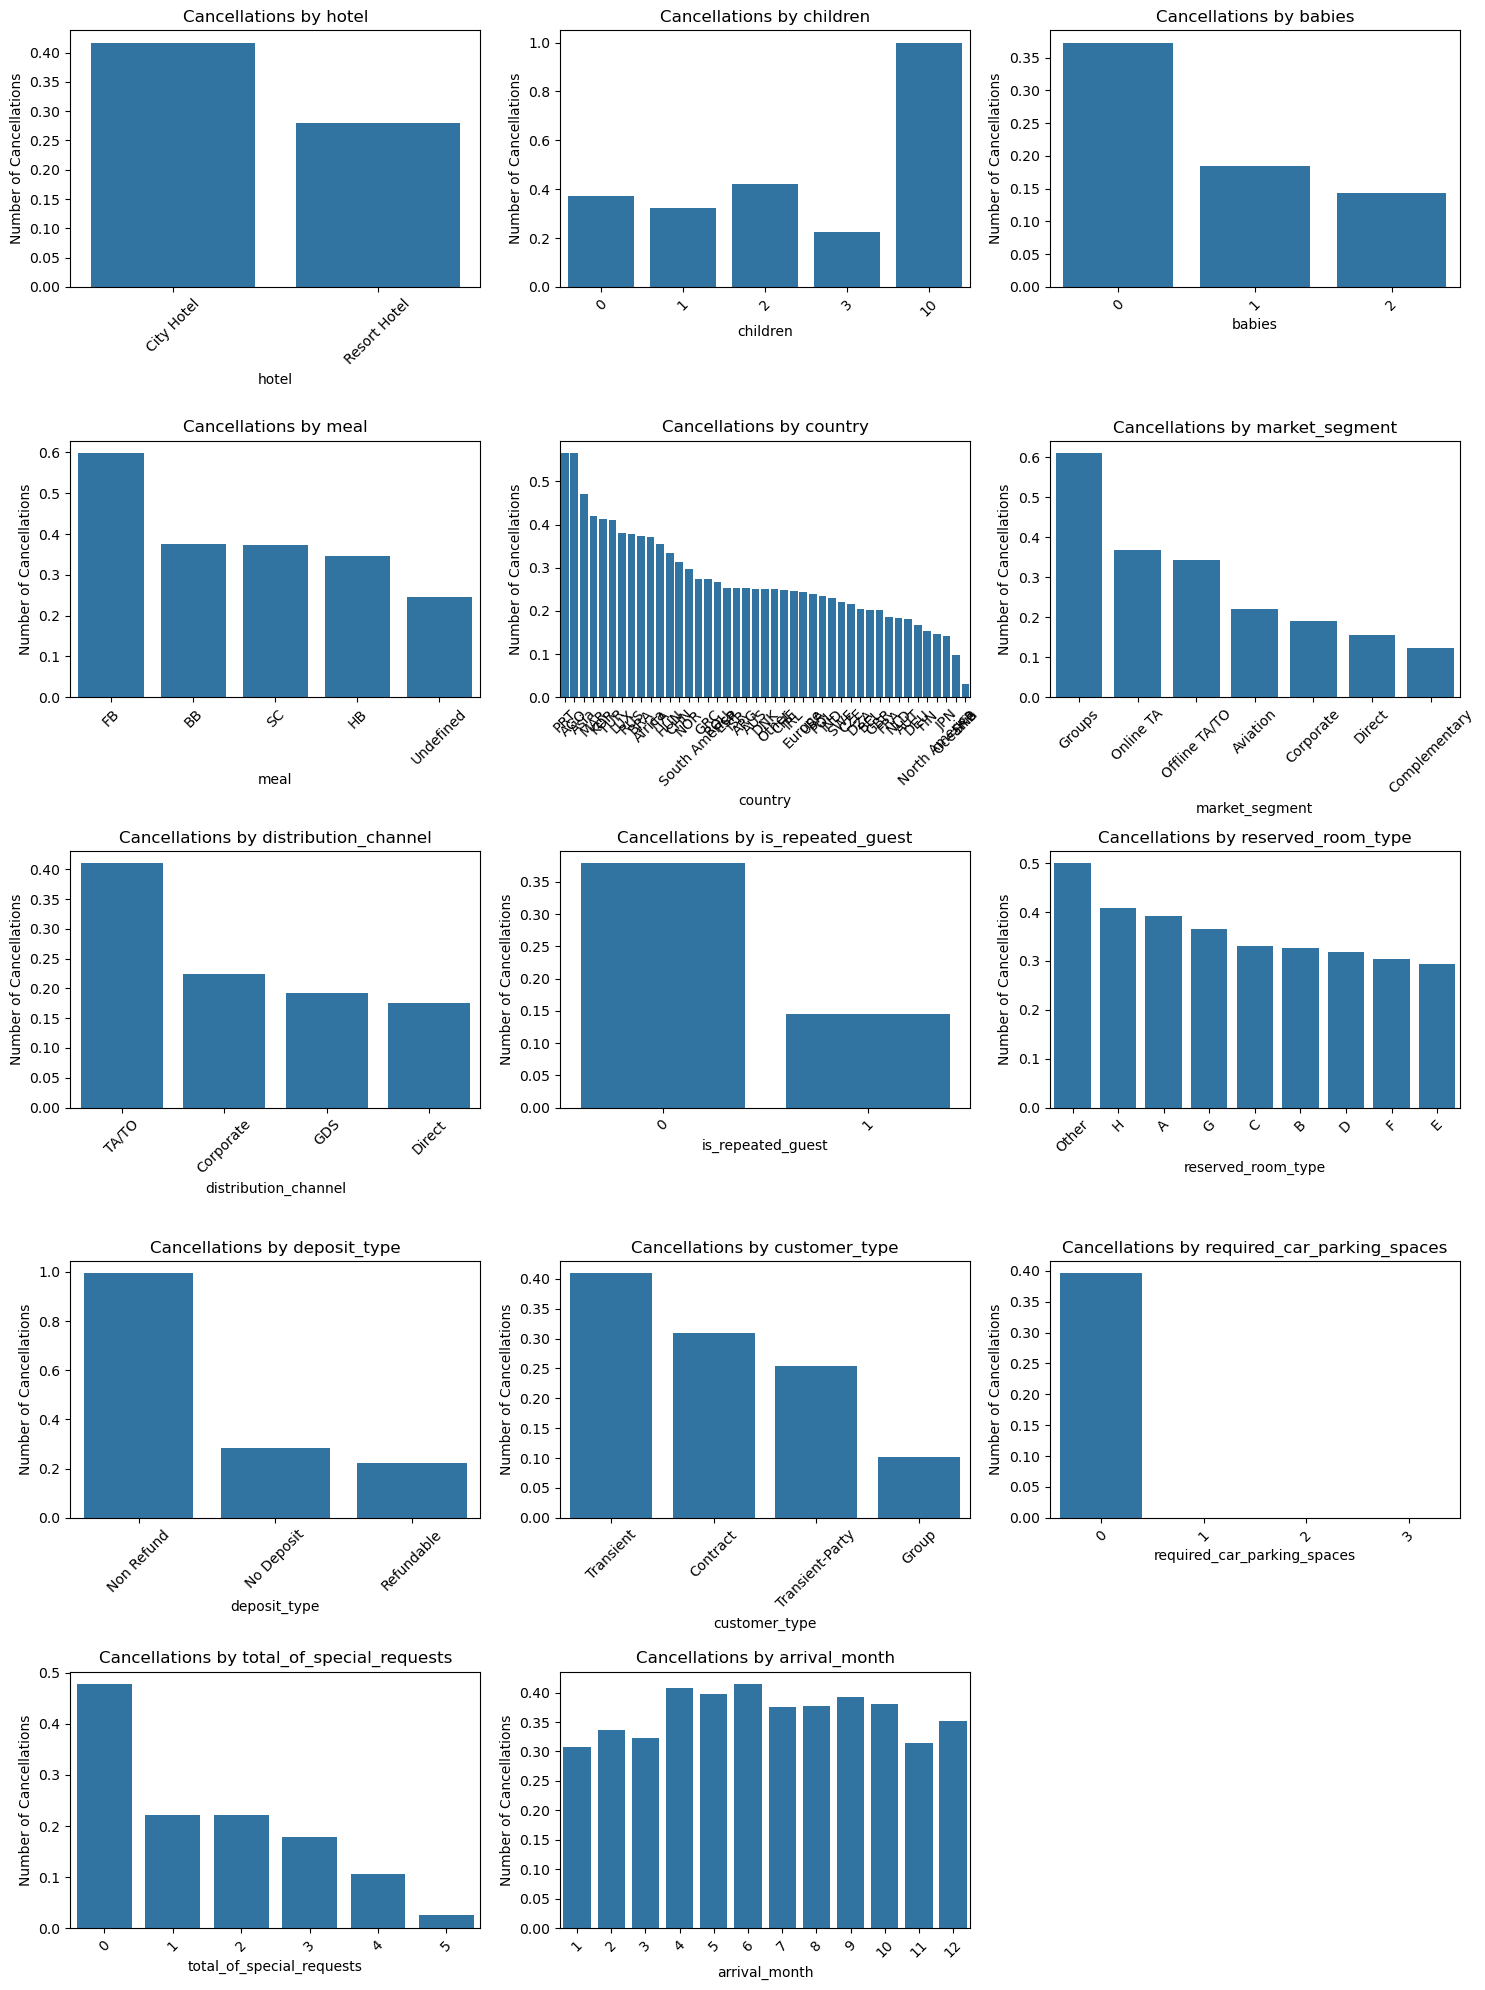

In [4]:
# bar charts

# Set up grid layout
cols_per_row = 3
num_plots = len(cat_cols)
rows = math.ceil(num_plots / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    grouped = df_nocodes.groupby(col)['is_canceled'].mean().sort_values(ascending=False)
    sns.barplot(x=grouped.index, y=grouped.values, ax=axes[i])
    axes[i].set_ylabel('Number of Cancellations')
    axes[i].set_title(f'Cancellations by {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

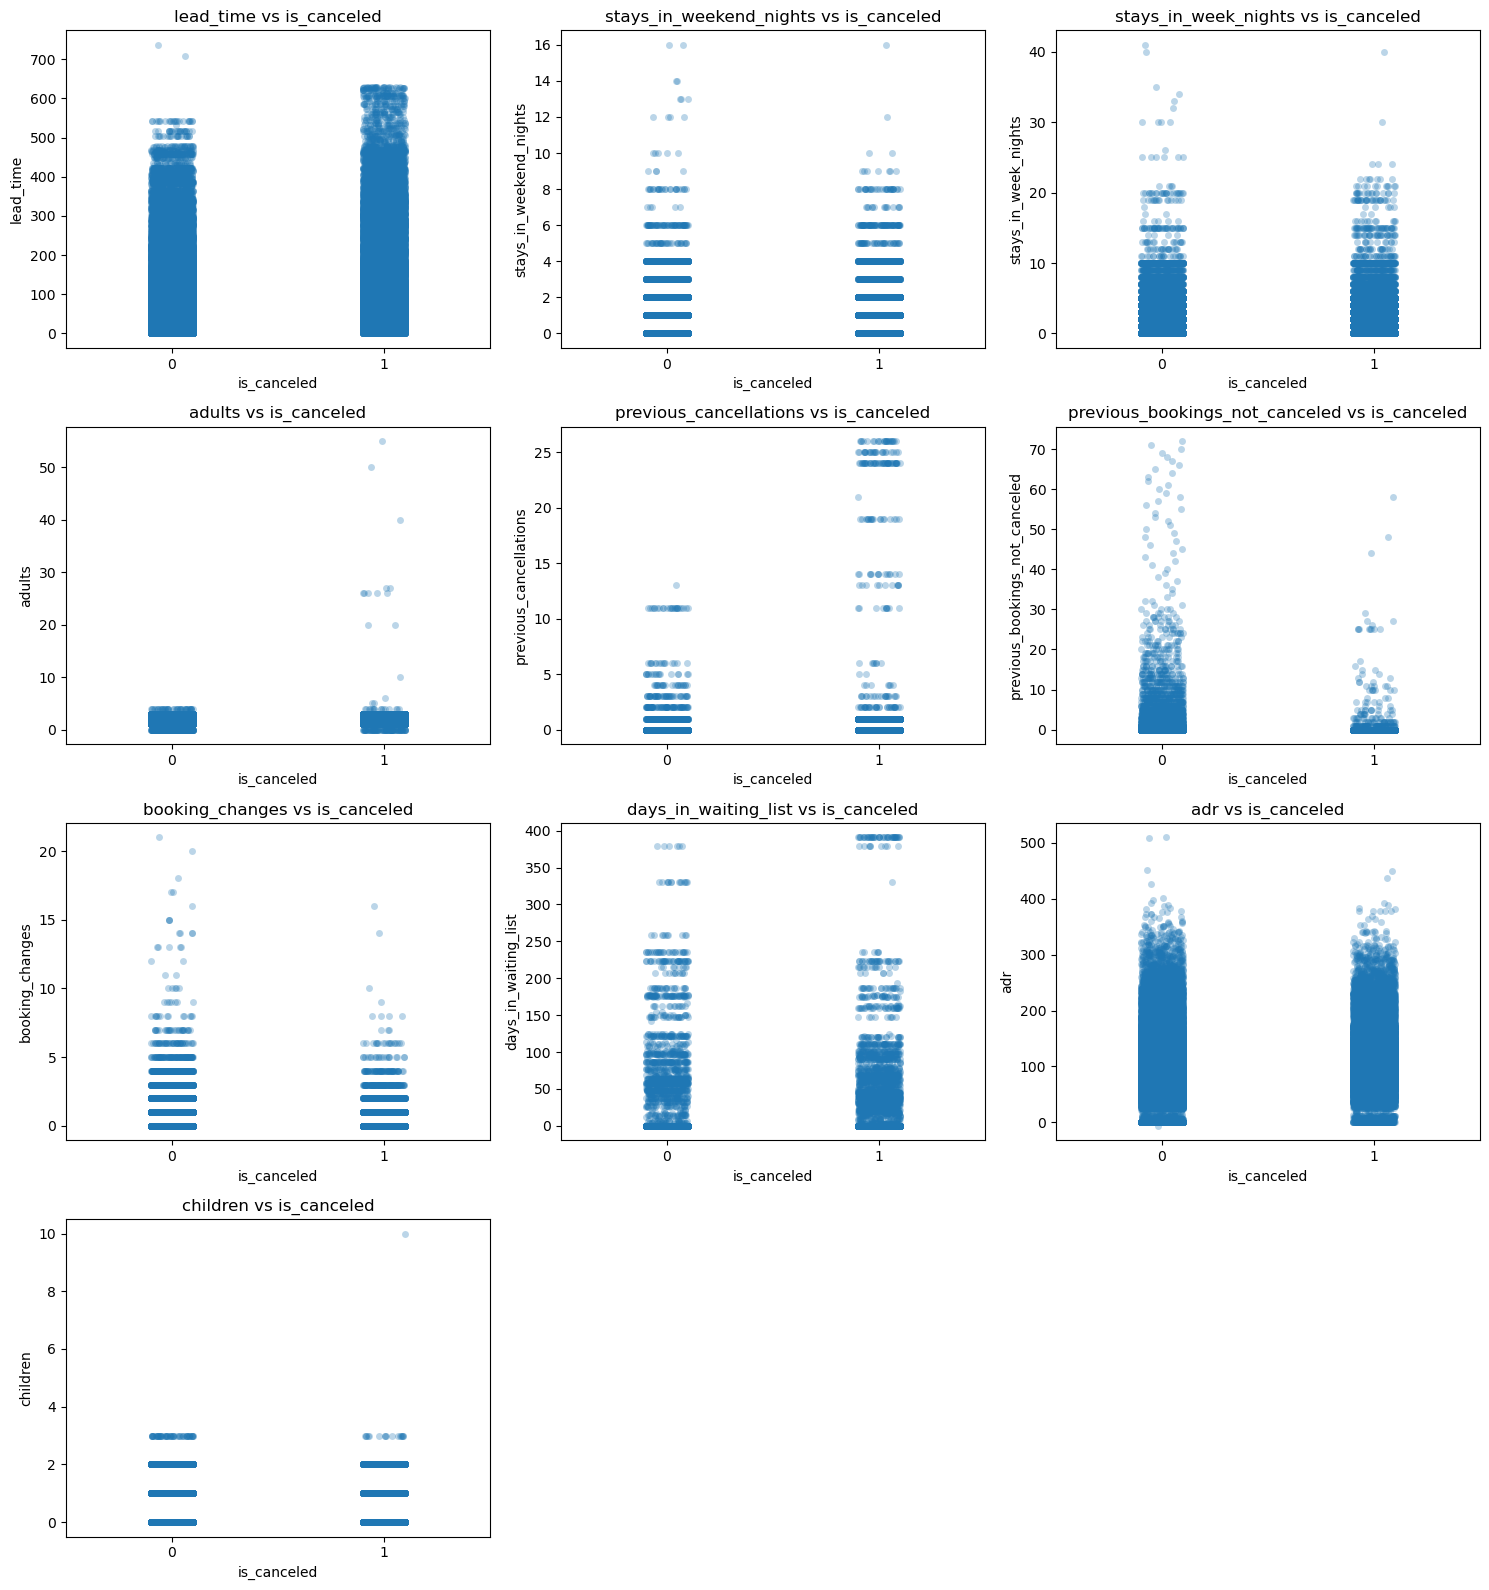

In [5]:
# stripplots for numericals

# Set up grid layout
cols_per_row = 3
num_plots = len(num_cols)
rows = math.ceil(num_plots / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.stripplot(x='is_canceled', y=col, data=df_nocodes, alpha=0.3, jitter=True, ax=axes[i])
    axes[i].set_title(f'{col} vs is_canceled')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Notable plots

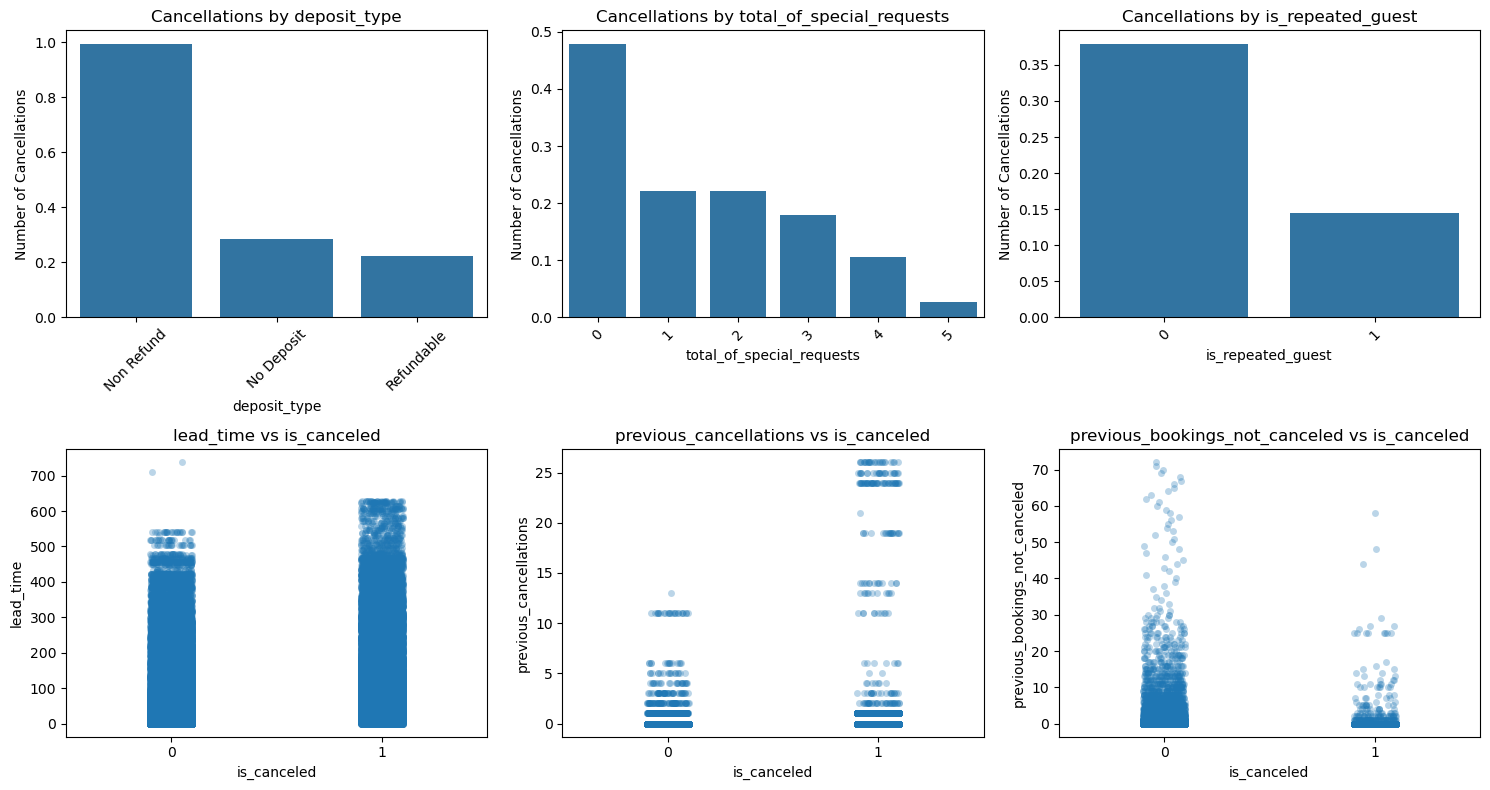

In [6]:
notable_cat = ['deposit_type', 'total_of_special_requests', 'is_repeated_guest']
notable_nums = ['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(notable_cat):
    grouped = df_nocodes.groupby(col)['is_canceled'].mean().sort_values(ascending=False)
    sns.barplot(x=grouped.index, y=grouped.values, ax=axes[i])
    axes[i].set_ylabel('Number of Cancellations')
    axes[i].set_title(f'Cancellations by {col}')
    axes[i].tick_params(axis='x', rotation=45)

for i, col in enumerate(notable_nums):
    sns.stripplot(x='is_canceled', y=col, data=df_nocodes, alpha=0.3, jitter=True, ax=axes[i+3])
    axes[i+3].set_title(f'{col} vs is_canceled')

plt.tight_layout()
plt.savefig("visual_analysis.png")
plt.show()

# Correlation Feature Analysis

In [7]:
# Sort absolute correlations with 'is_canceled'
correlations = df_codes.corr()['is_canceled'].drop('is_canceled')

# Show top 10 strongest correlations (positive or negative)
correlations.abs().sort_values(ascending=False).head(10)

deposit_type_Non Refund        0.481330
deposit_type_No Deposit        0.477772
country_PRT                    0.335418
lead_time                      0.291991
total_of_special_requests      0.235645
market_segment_Groups          0.221527
required_car_parking_spaces    0.196125
distribution_channel_TA/TO     0.174090
market_segment_Direct          0.153616
distribution_channel_Direct    0.150905
Name: is_canceled, dtype: float64

### Pearson on numerical features

In [8]:
p_values = []
c_values = {}

for col in num_cols:
    corr, p_val = stats.pearsonr(df_nocodes[col], df_nocodes['is_canceled'])
    p_values.append(p_val)
    c_values[col] = corr

p_values_df = pd.DataFrame.from_dict(c_values, orient='index', columns=['Pearson Correlation'])
p_values_df['p-value'] = p_values
p_values_df['Significant'] = p_values_df['p-value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
p_values_df.sort_values(by=['Pearson Correlation'], ascending=False).head(10)

,Pearson Correlation,p-value,Significant
lead_time,0.291991,0.000000e+00,Yes
previous_cancellations,0.109921,3.159284e-316,Yes
adults,0.058361,3.293579e-90,Yes
days_in_waiting_list,0.054067,1.130887e-77,Yes
adr,0.047295,7.542032e-60,Yes
stays_in_week_nights,0.024109,9.247359e-17,Yes
children,0.004757,1.009656e-01,No
stays_in_weekend_nights,-0.002618,3.667643e-01,No
previous_bookings_not_canceled,-0.055482,1.070428e-81,Yes
booking_changes,-0.144658,0.000000e+00,Yes


### Chi-square on categorical features

In [9]:
chi_square_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(df_nocodes[col], df_nocodes['is_canceled'])
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)
    chi_square_results[col] = {'chi2_stat': chi2_stat, 
                               'p_value': p_val,
                               'degrees_of_freedom': dof,
                               'sample_size': contingency_table.values.sum()
                              }
    

chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient='index')
chi_square_df['Significant'] = chi_square_df['p_value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
chi_square_df.rename(columns={'chi2_stat': 'Chi-Square Statistic', 'p_value': 'p-value', 'degrees_of_freedom': 'DOF', 'sample_size': 'N'}, inplace=True)

chi_square_df.sort_values(by=['Chi-Square Statistic'], ascending=False).head(10)

,Chi-Square Statistic,p-value,DOF,N,Significant
deposit_type,27546.733443,0.000000e+00,2,118889,Yes
country,14848.038453,0.000000e+00,42,118889,Yes
total_of_special_requests,8432.726272,0.000000e+00,5,118889,Yes
market_segment,8390.238147,0.000000e+00,6,118889,Yes
required_car_parking_spaces,4599.401898,0.000000e+00,3,118889,Yes
distribution_channel,3648.386544,0.000000e+00,3,118889,Yes
customer_type,2257.123527,0.000000e+00,3,118889,Yes
hotel,2132.930573,0.000000e+00,1,118889,Yes
is_repeated_guest,860.748409,3.348548e-189,1,118889,Yes
reserved_room_type,634.603996,8.469794e-132,8,118889,Yes


# Random Forest (Embedded Method) for Feature Importance

In [10]:
X = df_codes.drop(columns=['is_canceled'])
y = df_codes['is_canceled']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)
all_importances = []

rankings = []
accuracies = []
precisions = []
f1s = []
recalls = []

# Evaluate the model and get feature importances across cross-validation splits
for train_index, val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    rf_model.fit(X_kf_train, y_kf_train)
    importances = rf_model.feature_importances_
    all_importances.append(importances)

    y_pred = rf_model.predict(X_kf_val)

    accuracies.append(accuracy_score(y_kf_val, y_pred))
    precisions.append(precision_score(y_kf_val, y_pred, zero_division=np.nan))
    f1s.append(f1_score(y_kf_val, y_pred, zero_division=np.nan))
    recalls.append(recall_score(y_kf_val, y_pred, zero_division=np.nan))
    conf = confusion_matrix(y_kf_val, y_pred)


all_importances_df = pd.DataFrame(all_importances, columns=X.columns)

summary_importance_df = all_importances_df.T

summary_importance_df['Mean Importance'] = all_importances_df.mean()
summary_importance_df['Std Dev Importance'] = all_importances_df.std()

summary_importance_df = summary_importance_df.sort_values(by='Mean Importance', ascending=False)
feature_importances = summary_importance_df['Mean Importance']

summary_importance_df.head(15)

,0,1,2,3,4,5,6,7,8,9,Mean Importance,Std Dev Importance
lead_time,0.154896,0.155491,0.157385,0.155200,0.157157,0.155128,0.155963,0.152642,0.153846,0.155084,0.155279,0.001402
adr,0.108223,0.108792,0.108787,0.108707,0.107987,0.108924,0.109587,0.109160,0.108991,0.106835,0.108599,0.000765
country_PRT,0.070175,0.071288,0.071052,0.070304,0.074676,0.071944,0.066088,0.073140,0.069519,0.070741,0.070893,0.002273
total_of_special_requests,0.062280,0.060846,0.059216,0.060595,0.061654,0.060875,0.062423,0.061409,0.061229,0.060449,0.061098,0.000937
arrival_month,0.060552,0.060900,0.061360,0.061275,0.061540,0.061292,0.060943,0.061022,0.061424,0.060569,0.061088,0.000347
deposit_type_No Deposit,0.056295,0.062016,0.053599,0.054042,0.047642,0.053528,0.058142,0.057331,0.057285,0.056702,0.055658,0.003789
deposit_type_Non Refund,0.054284,0.046850,0.059081,0.058034,0.059121,0.057682,0.053998,0.052787,0.052622,0.057105,0.055156,0.003840
stays_in_week_nights,0.047456,0.047042,0.047785,0.046934,0.046825,0.046858,0.047063,0.047429,0.046861,0.046673,0.047093,0.000351
stays_in_weekend_nights,0.030158,0.029958,0.030084,0.030032,0.029863,0.030299,0.029841,0.029917,0.030563,0.029853,0.030057,0.000231
market_segment_Online TA,0.027908,0.026461,0.027734,0.027680,0.032871,0.030645,0.029097,0.030492,0.028871,0.027907,0.028967,0.001889


In [12]:
scores = np.array([accuracies, precisions, recalls, f1s]).T
df_scores = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1'])
df_scores.loc['Mean'] = df_scores.mean()
df_scores

,Accuracy,Precision,Recall,F1
0,0.878890,0.871222,0.788319,0.827700
1,0.875933,0.856209,0.793024,0.823406
2,0.882031,0.866708,0.799192,0.831582
3,0.879087,0.876653,0.791887,0.832117
4,0.880664,0.871019,0.791858,0.829554
5,0.883083,0.873795,0.799261,0.834868
6,0.881926,0.875586,0.794385,0.833011
7,0.872358,0.860372,0.784585,0.820732
8,0.881400,0.872205,0.803731,0.836569
9,0.878141,0.864715,0.795803,0.828829


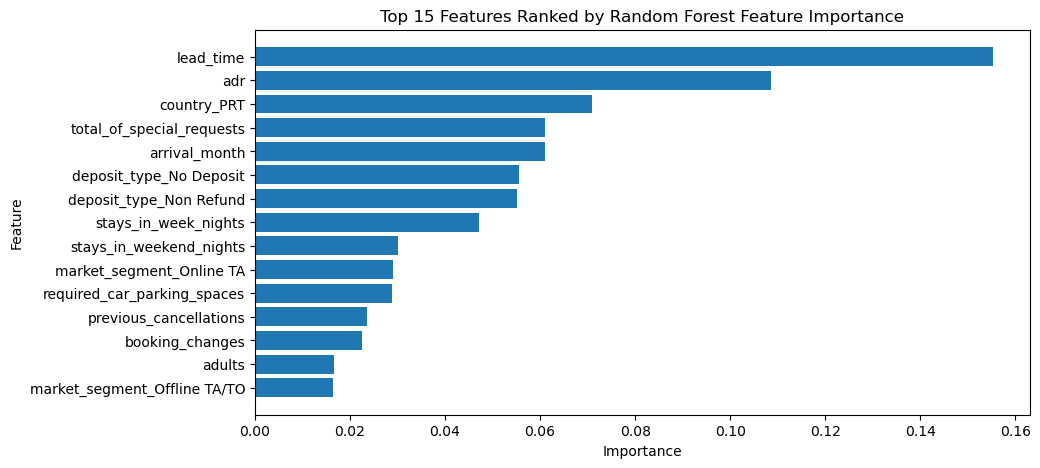

In [13]:
top_features = summary_importance_df.head(15)


plt.figure(figsize=(10, 5))
plt.barh(top_features.index, top_features["Mean Importance"])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 15 Features Ranked by Random Forest Feature Importance")

plt.savefig("RandomForest Features.png")
plt.show()

### Selection of features for RFE

RFE could not be run on the entire feature set due to performance issues.

So the top five from each method (pearson, chi-square, random forest) were chosen with some restrictions

Country was discarded because of problems with booking number confounding
distribution was discarded because of redundancy with market segment

In [14]:
features = ['lead_time', 'previous_cancellations', 'adults', 'days_in_waiting_list', 'adr',
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'total_of_special_requests', 'market_segment_Aviation', 'market_segment_Complementary', 
            'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 
            'market_segment_Offline TA/TO', 'market_segment_Online TA', 'required_car_parking_spaces',
            'arrival_month'
           ]

# RFE with Random Forest

In [15]:
X = df_codes[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)
all_importances = []

# Initialize RFE with Random Forest
rfe = RFE(estimator=rf_model, n_features_to_select=5)

rankings = []

# Evaluate the model and get feature importances across cross-validation splits
for train_index, val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    rfe.fit(X_kf_train, y_kf_train)
    rfe_rank = rfe.ranking_
    rankings.append(rfe_rank)

all_rankings_df = pd.DataFrame(rankings, columns=X.columns)

summary_importance_df = all_rankings_df.T

summary_importance_df['Mean Ranking'] = all_rankings_df.mean()
summary_importance_df['Std Dev Ranking'] = all_rankings_df.std()

summary_importance_df = summary_importance_df.sort_values(by='Mean Ranking')

summary_importance_df.head(10)

,0,1,2,3,4,5,6,7,8,9,Mean Ranking,Std Dev Ranking
lead_time,1,1,1,1,1,1,1,1,1,1,1.0,0.0
deposit_type_Non Refund,1,1,1,1,1,1,1,1,1,1,1.0,0.0
deposit_type_No Deposit,1,1,1,1,1,1,1,1,1,1,1.0,0.0
adr,1,1,1,1,1,1,1,1,1,1,1.0,0.0
arrival_month,1,1,1,1,1,1,1,1,1,1,1.0,0.0
total_of_special_requests,2,2,2,2,2,2,2,2,2,2,2.0,0.0
market_segment_Online TA,3,3,3,3,3,3,3,3,3,3,3.0,0.0
previous_cancellations,4,4,4,4,4,4,4,4,4,4,4.0,0.0
required_car_parking_spaces,5,5,5,5,5,5,5,5,5,5,5.0,0.0
adults,6,6,6,6,6,6,6,6,6,6,6.0,0.0


# Final Feature choices

Looking for 4 final features.

discarded adr because it would need further processing (see adr chart)

discarded arrival_month for same reason as country


In [16]:
features = ['lead_time', 
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'total_of_special_requests', 'market_segment_Aviation', 'market_segment_Complementary', 
            'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 
            'market_segment_Offline TA/TO', 'market_segment_Online TA', 'is_canceled'
           ]

X = df_codes[features]

Check if those features correlate with each other and are therefore redundant

N.B. I expect the one-hot encoded features to correlate with each other, looking for correlations between other features

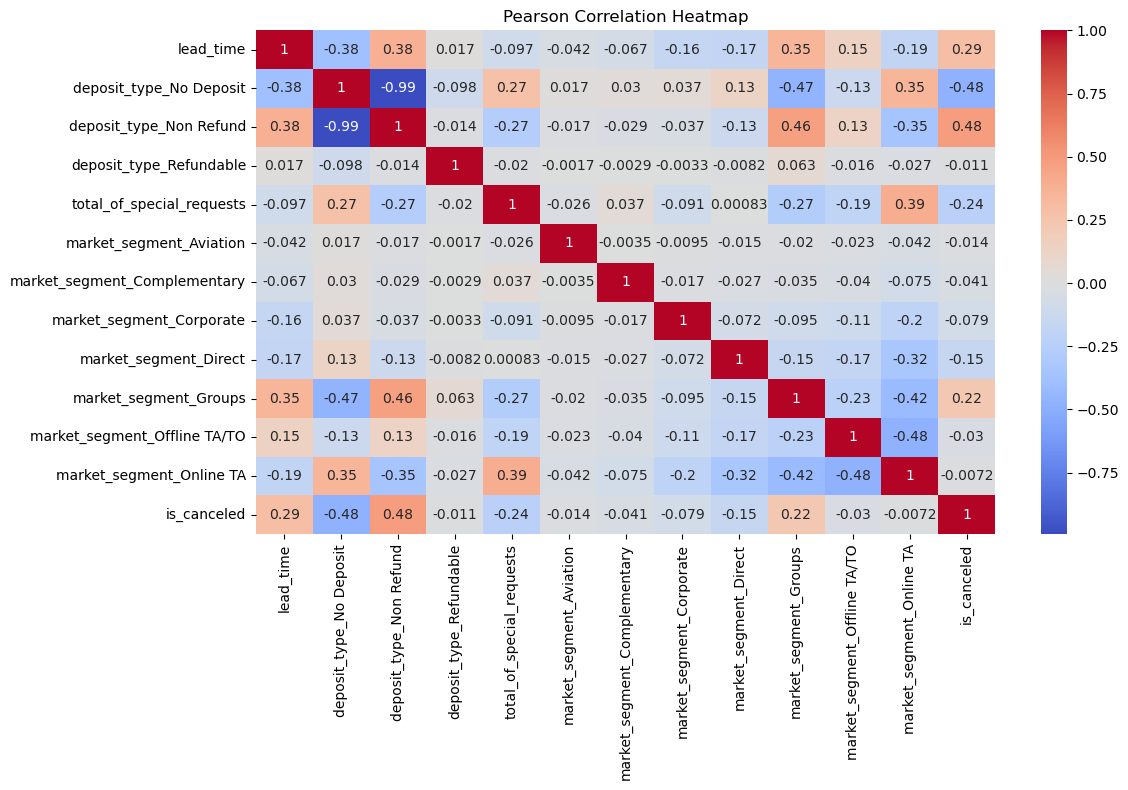

In [17]:
plt.figure(figsize=(12, 8))

correlation_matrix_pearson = df_codes[features].corr(method='pearson')
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')

# Adjust layout
plt.tight_layout()
plt.savefig("Redundancy Found.png")
plt.show()

Significant correlation between deposit type and market segment

discarding market segment and choosing the next top feature

In [18]:
features = ['lead_time', 
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'total_of_special_requests', 'previous_cancellations', 'is_canceled'
           ]

X = df_codes[features]

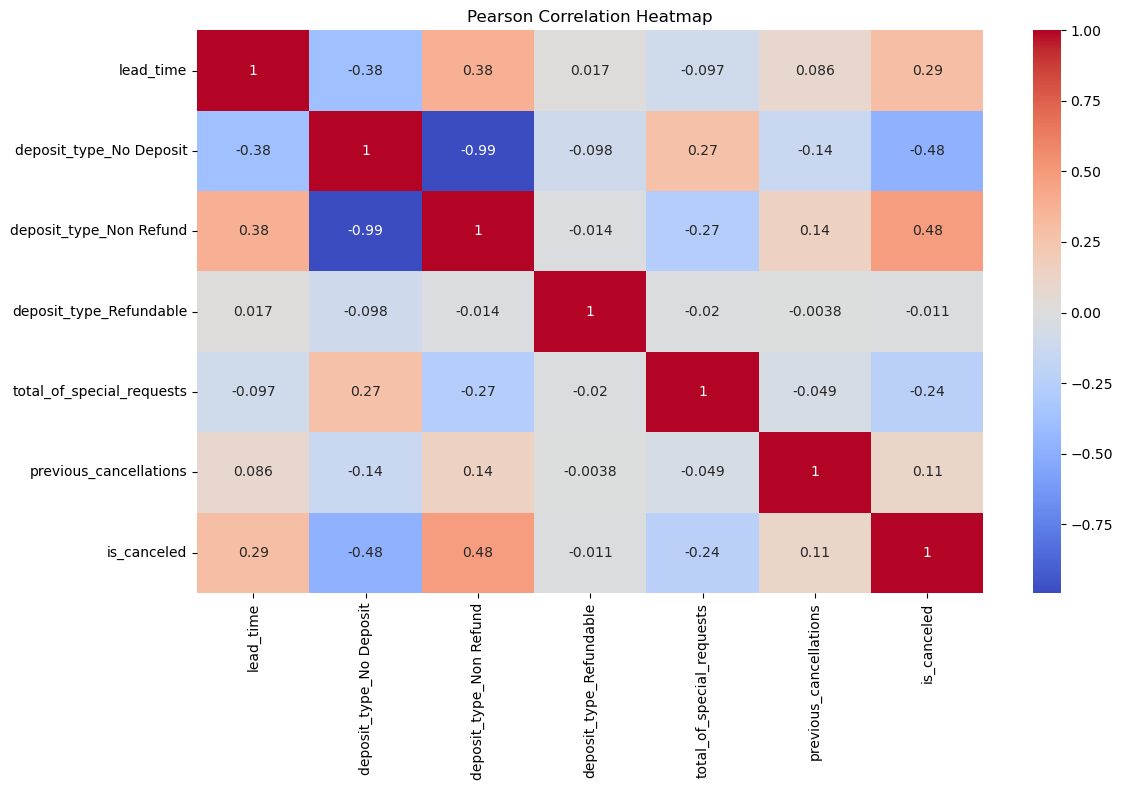

In [19]:
plt.figure(figsize=(12, 8))

correlation_matrix_pearson = df_codes[features].corr(method='pearson')
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')

# Adjust layout
plt.tight_layout()
plt.savefig("final features correlation.png")
plt.show()

In [20]:
features = ['lead_time', 
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'total_of_special_requests', 'previous_cancellations', 'is_canceled'
           ]

df = df_codes[features]

# save final version
df.to_csv("hotel_final_features.csv", index=False)